## 原始惑星円盤「連続波イメージよりダスト円盤の物理量を導出する」

今回使用するデータは、ALMAで観測された原始惑星系円盤を持つ「HL Tau」の連続波イメージデータです。<br>
ALMA Science Archiveより、以下を検索してください。<br>
- Project code: 2018.1.01037.S<br>
- Source Name: HL_Tau<br>

JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information :
    https://jvo.nao.ac.jp/portal/alma/archive.do?action=dataset.info&datasetId=ALMA01424653 <br>
- FITS link :
    http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01424653_00_00_00

### モジュールの読み込み（インストール）

最初に、Google Colab環境の場合、CASAモジュールをインストールしてCASA実行環境を構築する処理を行っています。

In [1]:
import sys, os
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [2]:
# For Google Colaboratory（Google Colab環境か判別し、Google Colab環境ならCASA実行環境を構築）
print(type(sys.modules))
moduleList = sys.modules
ENV_COLAB = False

if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")

if ENV_COLAB:
    print("Execute in google_colab")
#    print("installing pre-requisite packages...\n")

    print("installing casa packages...\n")
    !pip install casatools==6.6.0.20 # should install version 6.6.0 or later for Google Colab (python 3.10)
    !pip install casatasks==6.6.0.20
#    !pip install casatools
#    !pip install casatasks
    !pip install casadata

    print("make a config file for Google Colab...\n")
    !mkdir ~/.casa
    !echo "home     = '/content/'" > ~/.casa/config.py
    !echo "datapath = ['`find / -type d -name casadata`']" >> ~/.casa/config.py
    !more ~/.casa/config.py
    print("Completion of CASA preparation")

<class 'dict'>
google_colab
Execute in google_colab
installing casa packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 MB 2.8 MB/s eta 0:00:00
make a config file for Google Colab...

find: ‘/proc/58/task/58/net’: Invalid argument
find: ‘/proc/58/net’: Invalid argument
home     = '/content/'
datapath = ['/usr/local/lib/python3.10/dist-packages/casadata']
Completion of CASA preparation


In [3]:
import casatools
import casatasks

以下では必要なモジュールを読み込んでいます。<br>
ローカル環境で実行する場合は、以下で読み込んでいるモジュール及びCASAモジュールをあらかじめインストールしてから実行して下さい。

In [4]:
#import sys, os
import math
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
import astropy.wcs

### JVOよりイメージFITSデータのダウンロード

In [5]:
# continuum image data
url = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01424653_00_00_00'
orgimfits='ALMA01424653_00_00_00.fits'
myimages ='HL_Tau.cont'

url/orgimfitsではダウンロードするイメージFITSのURLとファイル名を指定しています。<br>
myimagesではダウンロードされたFITSを読み込んで、このスクリプト内で使用するイメージファイル名を指定していて、以後共通で使用します。

In [6]:
import urllib.request
if not (os.path.isfile(orgimfits)):
    print(f"downloading fits file.:  {orgimfits}")
    urllib.request.urlretrieve(url, orgimfits)

downloading fits file.:  ALMA01424653_00_00_00.fits


### FITSイメージ表示

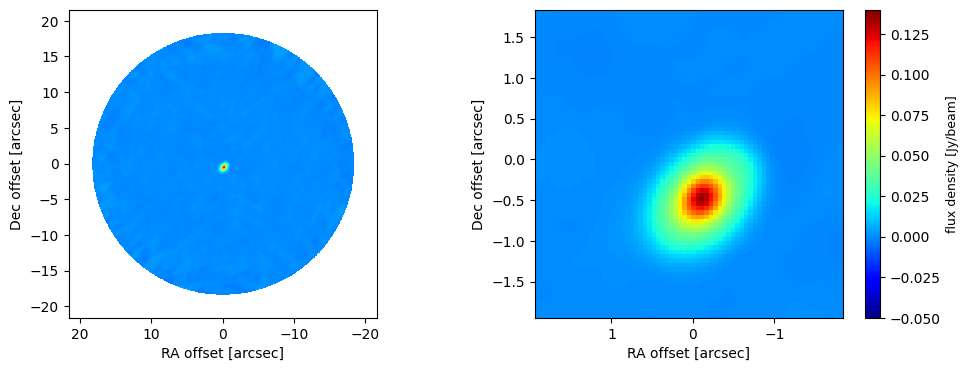

In [7]:
ftdata = fits.open(orgimfits)
ft_img = ftdata[0].data
ft_hdr = ftdata[0].header
ftdata.close()
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])

ft_hdr['CRVAL1']=0.0                       ; ft_hdr['CRVAL2']=0.0
ft_hdr['CRPIX1']=int(ft_hdr['NAXIS1']/2)+1 ; ft_hdr['CRPIX2']=int(ft_hdr['NAXIS2']/2)+1
ft_hdr['CDELT1']=ft_hdr['CDELT1']*3600     ; ft_hdr['CDELT2']=ft_hdr['CDELT2']*3600
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])

ofx_st=(ft_hdr['CRVAL1']+(              1 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+(ft_hdr['NAXIS1']-ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+(              1 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+(ft_hdr['NAXIS2']-ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st,ofx_ed,ofy_st,ofy_ed)

xmax=ft_hdr['NAXIS1'] ; ymax=ft_hdr['NAXIS2']
iwd=70 # zoom up area width [pixel]
blcx=int(xmax/2-iwd/2) ; trcx=int(xmax/2+iwd/2)
blcy=int(ymax/2-iwd/2) ; trcy=int(ymax/2+iwd/2)
#print(blcx,trcx,blcy,trcy,'/',xmax,ymax)

ofx_st2=(ft_hdr['CRVAL1']+( blcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed2=(ft_hdr['CRVAL1']+( trcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st2=(ft_hdr['CRVAL2']+( blcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed2=(ft_hdr['CRVAL2']+( trcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st2,ofx_ed2,ofy_st2,ofy_ed2)

ff, aa = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(wspace=0.1)
im = aa[0].imshow(ft_img[0,0,:,:], origin='lower', extent=(ofx_st,ofx_ed,ofy_st,ofy_ed),
                  vmin=-0.05, vmax=0.14, cmap='jet')
im = aa[1].imshow(ft_img[0,0,:,:], origin='lower', extent=(ofx_st,ofx_ed,ofy_st,ofy_ed),
                  vmin=-0.05, vmax=0.14, cmap='jet')
cbar=plt.colorbar(im, ax=aa[1])
cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
aa[1].set_xlim(ofx_st2,ofx_ed2)
aa[1].set_ylim(ofy_st2,ofy_ed2)
aa[0].set_xlabel("RA offset [arcsec]") ; aa[0].set_ylabel("Dec offset [arcsec]")
aa[1].set_xlabel("RA offset [arcsec]") ; aa[1].set_ylabel("Dec offset [arcsec]")
plt.savefig('HL_Tau.cont_fitsimage.png', bbox_inches="tight", pad_inches=0.05)

表示された図は、左はイメージデータ全域を表示、右は視野中心を拡大表示しています。右上から左下に延びた楕円形の連続波放射が見られます。

### イメージFITS読み込み

In [8]:
from casatasks import importfits
imname = myimages+'.pbcor'
importfits(fitsimage=orgimfits,
           imagename=imname, overwrite=True)

タスクimportfitsでイメージFITSをCASA形式の画像ファイルに変換します。<br>
fitsimageには入力イメージFITS名を、imagenameには出力されるCASA形式のファイル名(実体はディレクトリ)を指定します。それぞれ先に定義したファイル名を引用しています。

### ヘッダーから合成ビームサイズ（及び観測周波数）を確認

In [9]:
from casatasks import imhead
imname = myimages+'.pbcor'
imhd_A_res = imhead(imname)
bmaj  =imhd_A_res['restoringbeam']['major']['value']
bmajut=imhd_A_res['restoringbeam']['major']['unit']
bmin  =imhd_A_res['restoringbeam']['minor']['value']
bminut=imhd_A_res['restoringbeam']['minor']['unit']
bmpa  =imhd_A_res['restoringbeam']['positionangle']['value']
bmpaut=imhd_A_res['restoringbeam']['positionangle']['unit']
print('Synthesized Beam:')
print(f'   Major Axis = {bmaj:.7f} {bmajut}')
print(f'   Minor Axis = {bmin:.7f} {bminut}')
print(f'   Pos. Angle = {bmpa:.7f} {bmpaut}')
cfreq =imhd_A_res['refval'][2]
frequt=imhd_A_res['axisunits'][2]
if frequt == 'Hz':
    cfreqgh = cfreq/10**(9)
    print(f'Observing Frequency = {cfreqgh:.6f} GHz')
else:
    print(f'Observing Frequency = {cfreq:.1f} {frequt}')

Synthesized Beam:
   Major Axis = 0.2922270 arcsec
   Minor Axis = 0.2649764 arcsec
   Pos. Angle = 1.8701019 deg
Observing Frequency = 235.541305 GHz


タスクimheadを使ってイメージデータのヘッダから合成ビームサイズの情報を読み取ります。<br>
ヘッダからは、イメージデータの各座標/周波数軸値・ピクセル間隔・ピクセル数なども分かります。これらの情報は、上記では"imhd_A_res"に辞書オブジェクトとして読み込まれています。また、上記では観測周波数についても確認しています。

### イメージRMSを確認（その１）

In [10]:
from casatasks import imstat
imname = myimages+'.pbcor'
stats1=imstat(imagename=imname, region='box[[260pix,265pix],[360pix,535pix]]')
stats2=imstat(imagename=imname, region='box[[440pix,265pix],[540pix,535pix]]')
imgrms=(stats1['rms'][0]+stats2['rms'][0])/2
print(f'RMS [mJy/beam] of {imname} : {imgrms*1000:.7f}')

RMS [mJy/beam] of HL_Tau.cont.pbcor : 0.4689696


### イメージRMS（及び連続波放射ピーク）を確認（その２）

In [11]:
from casatasks import imstat
imname = myimages+'.pbcor'
ctx=400 ; cty=400 # center pixs
stats1=imstat(imagename=imname,
          region='annulus[['+str(ctx)+'pix,'+str(cty)+'pix],[4.5arcsec,14.0arcsec]]')
imgrms=stats1['rms'][0]
print(f'RMS [mJy/beam] of {imname} : {imgrms*1000:.7f}')
stats2=imstat(imagename=imname,
          region='circle[['+str(ctx)+'pix,'+str(cty)+'pix],4.5arcsec]')
imgmax=stats2['max'][0]
print(f'Max [mJy/beam] of {imname} : {imgmax*1000:.7f}')

RMS [mJy/beam] of HL_Tau.cont.pbcor : 0.4748368
Max [mJy/beam] of HL_Tau.cont.pbcor : 136.6068870


タスクimstatで、パラメータregionで指定された範囲内のイメージRMSやピーク値などの統計量を計算しています。<br>
領域"region"として、
- "box"はBLC (bottom left corner；左下), TRC (top right corner；右上)を設定して四角形領域を指定します。
- "circle"は中心位置と半径を設定して円形領域を指定します。
- "annulus"はリング状の領域を指定でき、中心位置とリングの内側・外側の半径を設定します。検出天体を避けてRMS等を求めるのに便利です。

イメージRMS（ノイズの大きさ）を測るときは、天体からの放射のない領域で測定する様にします。上記では、"box"で天体からずらして四角形領域を指定したり、"annulus"で天体を取り囲むリング領域を指定したりしています。<br>

regionの指定方法については、詳しくは以下をご覧ください。
<p style="padding-left:2em">
CASA Docs : <a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Region-File-Format" target="_blank" rel="noopener">Region File Format</a>
</p>

### ２次元ガウシアンフィットによる原始星の位置推定・長軸方向にスライスしたフラック密度分布

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


Gaussian fit :
   Peak flux = 0.1164 Jy/beam, FWHM = 0.8656 arcsec x 0.6385 arcsec (PA = 138.9841 deg)
   Center pos.= 04h31m38.42966731s +18d13m57.17203199s at (401.95pix, 391.1379pix)


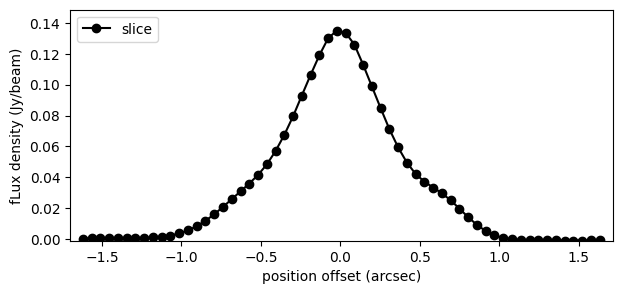

In [12]:
from casatasks import exportfits
exportfits(imagename=imname, fitsimage=imname+'.fits', dropdeg=True, overwrite=True)
ftdat = astropy.io.fits.open(imname+'.fits')
wcs = astropy.wcs.WCS(ftdat[0].header)

from casatasks import imfit
imname = myimages+'.pbcor'
xfit_A_res = imfit(imname)
xfit_A = xfit_A_res['results']['component0']
xxx0 = math.degrees(xfit_A['shape']['direction']['m0']['value'])
yyy0 = math.degrees(xfit_A['shape']['direction']['m1']['value'])
pixx0,piyy0 = wcs.wcs_world2pix(xxx0, yyy0, 0)
ctpix = int(np.round(pixx0))
ctpiy = int(np.round(piyy0))
#print(' initial center position for fitting: ('+str(ctpix)+'pix,'+str(ctpiy)+'pix)')

os.system('rm -rf '+imname+'.imfit_*')
xfit_B_res = imfit(imname,
                region = 'circle[['+str(ctpix)+'pix,'+str(ctpiy)+'pix],1.5arcsec]',
                newestimates = imname+'.imfit_estimates',
                logfile = imname+'.imfit_log')
xfit_B=xfit_B_res['results']['component0']
Flux  =xfit_B['peak']['value']                   ; FluxUn=xfit_B['peak']['unit']
Gmajor=xfit_B['shape']['majoraxis']['value']     ; GmajUn=xfit_B['shape']['majoraxis']['unit']
Gminor=xfit_B['shape']['minoraxis']['value']     ; GminUn=xfit_B['shape']['minoraxis']['unit']
Gpa   =xfit_B['shape']['positionangle']['value'] ; GpaUn =xfit_B['shape']['positionangle']['unit']
xxx1 = math.degrees(xfit_B['shape']['direction']['m0']['value'])
yyy1 = math.degrees(xfit_B['shape']['direction']['m1']['value'])
print('Gaussian fit :')
print("   Peak flux = %6.4f %s, FWHM = %6.4f %s x %6.4f %s (PA = %6.4f %s)"
            % (Flux,FluxUn,Gmajor,GmajUn,Gminor,GminUn,Gpa,GpaUn))

#au  = 1.49597870700*10**(11) # m/AU
#pc  = 3.085677581*10**(16)   # m/pc
#dist= 140. # pc @ HL Tau
#radi=dist*(pc/au)*math.tan(math.radians(Gmajor/3600))/2
#incl=math.degrees(math.asin(Gminor/Gmajor))
#print(f'Disk radius & inclination = {radi:.4f} AU, {incl:.4f} deg')

from astropy import units as u
from astropy.coordinates import SkyCoord
pixx1,piyy1 = wcs.wcs_world2pix(xxx1, yyy1, 0)
pixx1 = np.round(pixx1, 4) ; piyy1 = np.round(piyy1, 4)
ccskcd = SkyCoord(ra=xxx1*u.degree, dec=yyy1*u.degree)
print('   Center pos.=', ccskcd.to_string('hmsdms'), 'at ('+str(pixx1)+'pix, '+str(piyy1)+'pix)')

hspp=60 # pix
blcx=int(np.round(pixx1-hspp/2.*math.cos(math.radians(Gpa-90.))))
blcy=int(np.round(piyy1-hspp/2.*math.sin(math.radians(Gpa-90.))))
trcx=int(np.round(pixx1+hspp/2.*math.cos(math.radians(Gpa-90.))))
trcy=int(np.round(piyy1+hspp/2.*math.sin(math.radians(Gpa-90.))))

from casatools import image
ia = image()
ia.open(infile=imname)
rec = ia.getslice(x=[blcx,trcx], y=[blcy,trcy], npts=hspp)
ia.close()

path_w = 'HL_Tau.cont_majaxis_profile.csv'
rec_dp = [str(n)+','+str(m) for n,m in zip(rec['distance'],rec['pixel'])]
with open(path_w, mode='w') as f:
    f.write('\n'.join(rec_dp))
f.close()

xincr = abs(ftdat[0].header['CDELT1']*3600)
dt1_ax = (rec['distance']-hspp/2.)*xincr
dt1_fl = rec['pixel']
ff, aa = plt.subplots(1,1, figsize=(7,3))
imr = aa.plot(dt1_ax, dt1_fl, "o-", color="k", label="slice")
aa.set_xlim(-abs(min(dt1_ax)*1.05),max(dt1_ax)*1.05)
aa.set_ylim(-abs(min(dt1_fl)*1.1), max(dt1_fl)*1.1)
aa.set_xlabel("position offset (arcsec)")
aa.set_ylabel("fLux density ("+FluxUn+")")
aa.legend(loc="upper left")
plt.savefig('HL_Tau.cont_majaxis_profile.png', bbox_inches="tight", pad_inches=0.05)

タスクimfitで連続波放射に対して2次元ガウシアンフィットを行っています。フィッティング結果から、楕円ガウシアンのピークフラックス密度と長軸・短軸の半値全幅(FWHM)・位置角(PA)及び中心位置が求められています。ガウシアンの中心位置から、原始星の位置を推定出来ます。中心位置の結果を、原始星（HL Tau）の座標と比較してみてください。<br>
また、ガウシアンの中心を基準に長軸方向にスライスしたフラックス密度プロファイルを作成しています（CASA Toolkitのimage.getsliceを使っています。この結果はcsvファイルへも書き出されます）。実際には単純なガウシアンではなく、ピークの両側に緩やかに広がる成分があるのが分かります。この部分が円盤の成分と考えられます。

### 連続波イメージの5 &#x3C3;以上の放射からダスト円盤の半径・傾き推定

major/minor axes of 5.00 sigma area = 1.9980 [arcsec] x 1.5120 [arcsec]
Disk radius & inclination = 139.8600 AU, 49.1791 deg


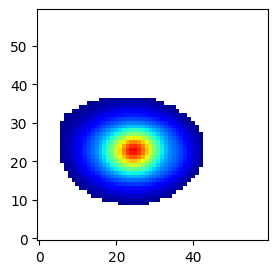

In [13]:
from casatools import image
imname = myimages+'.pbcor'
imname0 = imname +'.rot'
rotpa = -Gpa+90.
ia = image()
ia.open(infile=imname)
imr = ia.rotate(outfile=imname0, pa=str(rotpa)+GpaUn, overwrite=True)
imr.done()
ia.close()

from casatasks import immath
from casatasks import exportfits
imname1 = imname0 +'.zoom_thrd'
nsigma = 5.0               # <nsigma> threshold
threshold = imgrms*nsigma
ctx=400 ; cty=400 ; iwd=60 # center pixs & image width
blcx=int(ctx-iwd/2) ; trcx=int(ctx+iwd/2)
blcy=int(cty-iwd/2) ; trcy=int(cty+iwd/2)
box1=','.join([str(blcx), str(blcy), str(trcx), str(trcy)])
os.system('rm -rf '+imname1)
immath(imagename=[imname0],
       expr='IM0[IM0>%f]'%threshold,
       box = box1,
       outfile=imname1)
exportfits(imagename=imname1, fitsimage=imname1+'.fits',
       dropstokes=True, overwrite=True)

from casatasks import imval
box2=','.join([str(0), str(0), str(iwd-1), str(iwd-1)])
imv_res = imval(imagename=imname1, box=box2)
#print(imv_res['axes'])
imv_data = imv_res['data']
imv_mask = imv_res['mask']
imv_dt_tp = imv_data.transpose(1,0)
imv_mk_tp = imv_mask.transpose(1,0)
np.putmask(imv_dt_tp, imv_mk_tp==False, "0")
xslice = imv_dt_tp.sum(0)
yslice = imv_dt_tp.sum(1)
nxpix = np.sum( np.where(xslice > 0, 1, xslice) )
nypix = np.sum( np.where(yslice > 0, 1, yslice) )
np.putmask(imv_dt_tp, imv_mk_tp==False, "nan")

from casatasks import imhead
imhd_A_res = imhead(imname1)
incrx = abs(math.degrees(imhd_A_res['incr'][0])*3600)
incry = abs(math.degrees(imhd_A_res['incr'][1])*3600)
if nypix*incry >= nxpix*incrx:
    Gmajor = nypix*incry
    Gminor = nxpix*incrx
else:
    Gmajor = nxpix*incrx
    Gminor = nypix*incry
print(f'major/minor axes of {nsigma:.2f} sigma area = {Gmajor:.4f} [arcsec] x {Gminor:.4f} [arcsec]')

au  = 1.49597870700*10**(11) # m/AU
pc  = 3.085677581*10**(16)   # m/pc
dist= 140. # pc @ HL Tau
radi=dist*(pc/au)*math.tan(math.radians(Gmajor/3600))/2
incl=math.degrees(math.asin(Gminor/Gmajor))
print(f'Disk radius & inclination = {radi:.4f} AU, {incl:.4f} deg')

imgview=1 # rotating image is shown to chack rotation angle.
if imgview == 1:
    ff, aa = plt.subplots(1,1, figsize=(4,3))
    imr = aa.imshow(imv_dt_tp, origin='lower', vmin=0.0, vmax=0.15, cmap='jet')

連続波イメージの5 &#x3C3;以上の放射を持つ範囲をダスト円盤の見かけの大きさと考えて、長軸・短軸径からダスト円盤の半径・傾きを求めます。<br>
上記では指定した位置角PA（Position Angle: デフォルトでは前述のgaussian fitのPA）分だけイメージを回転させ、5 &#x3C3;以上のフラックス密度を持つ領域を切り出したイメージを作成し、X方向・Y方向にデータのあるピクセルの個数から長軸・短軸径を推定しています。（閾値を5 &#x3C3;から変えたい場合は"nsigma"を変更して下さい）<br>
厚みが十分薄い軸対称な円盤を斜めから見ていると仮定すると、見た目の長軸径が円盤の直径に相当します。
また、円盤の傾き(inclination: face onより) inclは、軸比より $({\rm minor\:axis})/({\rm major\:axis})=\sin(90-incl)$ の関係になり、これらの関係からダスト円盤の半径・傾きが求められます。
半径の物理的な長さ$r$は、視直径$\theta$・天体までの距離$D$とすると $\tan\theta=r/D$ の関係として計算しています。また、ターゲット天体HL Tauまでの距離は140 pcと仮定しています。<br>
なお、上記スクリプト最後でimgview=1を指定すると、ここで回転させたイメージを表示でき、指定した位置角の回転で長軸がX軸と平行になっているか確認出来ます。

### 連続波イメージの5 &#x3C3;以上の放射よりのトータルフラックスを算出、ダスト質量を推定

Total Flux [Jy] of HL_Tau.cont.pbcor.zoom_thrd : 0.8354889


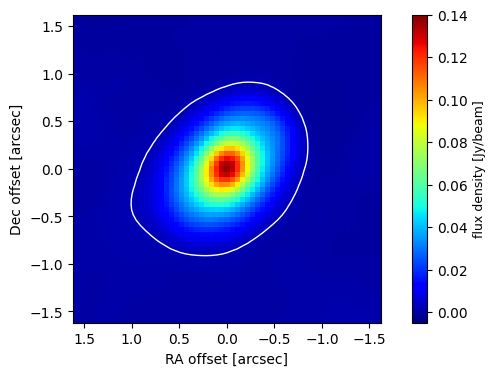

In [14]:
from casatasks import immath
from casatasks import imsubimage
from casatasks import exportfits
imname = myimages+'.pbcor'
imname2 = imname+'.zoom_thrd'
imname3 = imname+'.zoom'
#nsigma = 5.0               # <nsigma> threshold
#threshold = imgrms*nsigma
ctx=402 ; cty=391 ; iwd=60 # center pixs & image width
blcx=int(ctx-iwd/2) ; trcx=int(ctx+iwd/2)
blcy=int(cty-iwd/2) ; trcy=int(cty+iwd/2)
box3=','.join([str(blcx), str(blcy), str(trcx), str(trcy)])
os.system('rm -rf '+imname2)
immath(imagename=[imname],
       expr='IM0[IM0>%f]'%threshold,
       box = box3,
       outfile=imname2)
os.system('rm -rf '+imname3)
imsubimage(imagename=imname,
       box = box3,
       outfile=imname3)
for name in [imname2, imname3]:
    exportfits(imagename=name, fitsimage=name+'.fits',
               dropstokes=True, overwrite=True)

from casatasks import imstat
stats=imstat(imagename=imname2)
imgflx=stats['flux'][0]
imgnpt=stats['npts'][0]
imgsum=stats['sum'][0]
print(f'Total Flux [Jy] of {imname2} : {imgflx:.7f}')
#print(f'npts [pix] of {imname2} : {imgnpt:.0f}')
#print(f'sum [Jy] of {imname2} : {imgsum:.7f}')

ftdata = fits.open(imname3+'.fits')
ft_img = ftdata[0].data
ft_hdr = ftdata[0].header
ftdata.close()

ft_hdr['CRVAL1'] = 0.0                   ; ft_hdr['CRVAL2'] = 0.0
ft_hdr['CRPIX1'] = iwd/2+1               ; ft_hdr['CRPIX2'] = iwd/2+1
ft_hdr['CDELT1'] = ft_hdr['CDELT1']*3600 ; ft_hdr['CDELT2'] = ft_hdr['CDELT2']*3600
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])

ofx_st=(ft_hdr['CRVAL1']+(              1 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+(ft_hdr['NAXIS1']-ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+(              1 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+(ft_hdr['NAXIS2']-ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st,ofx_ed,ofy_st,ofy_ed)

colors = ['white'] ; levels = [threshold]
xcont = np.arange(np.size(ft_img[0,:,:], axis=0))
ycont = np.arange(np.size(ft_img[0,:,:], axis=1))
xcont2 = (ft_hdr['CRVAL1']+( (xcont+1) -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ycont2 = (ft_hdr['CRVAL2']+( (ycont+1) -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])

ff, aa = plt.subplots(1,1, figsize=(8,4))
imr = aa.imshow(ft_img[0,:,:], origin='lower',
                extent=(ofx_st,ofx_ed,ofy_st,ofy_ed), vmin=-0.005, vmax=0.14, cmap='jet')
imc = aa.contour(xcont2, ycont2, ft_img[0,:,:], colors=colors, levels=levels, linewidths=1.0)
cbar=plt.colorbar(imr, ax=aa)
cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
aa.set_xlabel("RA offset [arcsec]") ; aa.set_ylabel("Dec offset [arcsec]")
aa.set_xlim(ofx_st,ofx_ed) ; aa.set_ylim(ofy_st,ofy_ed)
plt.savefig('HL_Tau.cont_thrd_image.png', bbox_inches="tight", pad_inches=0.05)

連続波放射が5 &#x3C3;閾値以上の領域を切り出して、トータルフラックスを求めています。
図は連続波イメージのカラー表示に5 &#x3C3;レベルのコントアを重ねて表示していて、ここではこのコントア内部の総連続波フラックスを求めています。<br>
この連続波放射の起源がダストからの熱放射と仮定すると、ここで求めた連続波トータルフラックスより円盤のダスト質量は以下の様に求められます。

In [15]:
import math
hhh = 6.626*10**(-34) # J*s   Planck constant
ccc = 2.998*10**(8)   # m/s   speed of light
kkb = 1.381*10**(-23) # J/K   Boltzmann constant
pcc = 3.087*10**(16)  # m/pc  parsec
Mso = 1.989*10**(30)  # kg    Solar mass
J2E = 10**(-26)       # 1 Jy = 10-26 W m^-2 Hz^-1

# for HL Tau
dist = 140. # pc   distance
Tdust = 20. # K    dust temperature

imname = myimages+'.pbcor'
nu = imhead(imname)['refval'][2] # Hz   observing frequency
Fcont = imgflx                   # Jy   continuum flux

# Planck function
Bpf = ( (2.*hhh*nu**3) / (ccc**2) ) / ( math.exp((hhh*nu)/(kkb*Tdust))-1 )
# dust opacity (Beckwith et al. 1990)
kap = 10*((nu/(10**9))/1000) / 10  # m^2 kg^-1
# dust mass (Mo)
Mdust = (Fcont*J2E*(dist*pcc)**2) / (kap*Bpf) / Mso
print(f'Dust mass on disk = {Mdust:.6f} Mo')

Dust mass on disk = 0.001313 Mo


連続波トータルフラックスよりダスト質量$M_{\rm dust}$を導出は以下の式の様に表されます。
$$M_{\rm dust}= \frac{F_{\rm \nu}\,d^2}{\kappa_{\rm \nu}\,B_{\rm \nu}(T_{\rm dust})}$$
ここで$F_{\rm \nu}$がトータルフラックス、$d$は天体までの距離、$T_{\rm dust}$はダストの温度を表し、$B_{\rm \nu}(T_{\rm dust})$はダスト温度$T_{\rm dust}$におけるプランク関数（黒体放射の放射エネルギー）を表します。<br>
$$B_{\rm \nu}(T)=\frac{2h\nu^3}{c^2} \frac{1}{\mathrm{e}^{h\nu/k_{\rm B}T}-1}\;{\rm [J\,s^{-1}\,m^{-2}\,Hz^{-1}\,sr^{-1}]}$$
$\kappa_{\rm \nu}$はダストのオパシティ（opacity・吸収係数）を表し、ここでは $\kappa_{\rm \nu}=10\,(\nu/1000\,{\rm GHz})\;{\rm [cm^2\,g^{-1}]}$ としています(Beckwith et al. 1990)。
より一般的には$\kappa_{\rm \nu}$は周波数の指数関数 $\kappa_{\rm \nu}\propto\nu^{\beta}$ で近似されますが、この式では$\beta=1$を仮定しています。
オパシティ$\kappa_{\rm \nu}$は$\beta$を含めて不定性の大きな値であることにご注意下さい。<br>
なお、HL Tauまでの距離は$d$=140 pc、ダスト温度は$T_{\rm dust}$=20 Kを仮定しています。

In [16]:
print('END')

END
